In [11]:
%load_ext autoreload
%autoreload 2

import numpy as np

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, sublevelset_heading_persistence
from functions.data_loading import flights_from_query, get_flight_persistances
from functions.objects import PersistenceData, Models

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from traffic.core import Traffic, Flight

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
flights, data = flights_from_query(None, "data/unbalanced1_2_3_4.pkl", load_results=True)
simple = False
classification = False

In [13]:
filtered_flight_data = [(f, d) for f, d in zip(flights, data) if large_gap_filter(f)]
flights, data = zip(*filtered_flight_data)  
flights = list(flights)
data = np.array(data)

labels = data[:, 0]
if simple: 
    labels = (labels != 1).astype(int)

outside_data = data[:, 1:]

In [14]:
pers_objects = get_flight_persistances(flights, "balanced_flight_persistances.pkl", load_results=True)
LL_data, A_data, S_data, H_data = pers_objects

C:\Users\tobso\Desktop\programering\masters-thesis\functions\objects.py:89: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  axs[0].scatter(path[:, 0], path[:, 1], cmap="plasma", edgecolors="none")


array([[0.11501527, 0.23003054, 0.34504581, ..., 0.        , 0.        ,
        0.        ],
       [0.05419372, 0.10838745, 0.16258117, ..., 0.        , 0.        ,
        0.        ],
       [0.20723784, 0.41447568, 0.62171352, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.8790556 , 1.7581112 , 2.63716679, ..., 0.        , 0.        ,
        0.        ],
       [0.74068718, 1.48137435, 2.22206153, ..., 0.        , 0.        ,
        0.        ],
       [0.91308154, 1.82616309, 2.73924463, ..., 0.        , 0.        ,
        0.        ]])

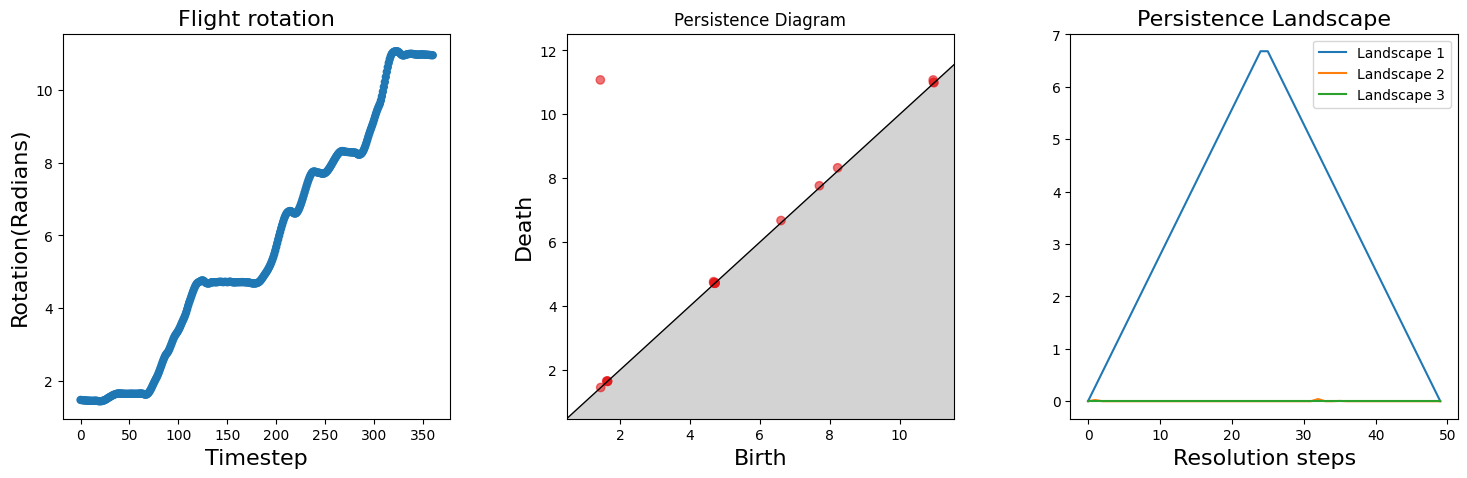

In [15]:
from gudhi.representations import Landscape

index = 3027
dataset = 3

pers = pers_objects[dataset]
pers.landscape_model = Landscape(num_landscapes=3, resolution=50, keep_endpoints=True)
pers.compute_landscapes()
fig = pers.plot_diagram(index, add_landscape=True)
#fig.savefig("H_example.svg", format="svg", dpi=1000)
pers.landscape_model = Landscape(num_landscapes=3, resolution=20, keep_endpoints=False)
pers.compute_landscapes()

In [16]:
from tqdm import tqdm
baseline = []

for flight in tqdm(flights, total=len(flights)):
    data = flight.data.copy(deep=True)
    
    unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
    max_unwrapped = unwrapped.max()
    min_unwrapped = unwrapped.min()
    diff_unwrapped = max_unwrapped - min_unwrapped
    
    max_velocity = data["groundspeed"].max()
    min_velocity = data["groundspeed"].min()
    mean_velocity = data["groundspeed"].mean()
    max_heading = data["vertical_rate"].max()
    min_heading = data["vertical_rate"].min()
    mean_heading = data["vertical_rate"].mean()
    longitude_diff = data["longitude"].max() - data["longitude"].min()
    latitude_diff = data["latitude"].max() - data["latitude"].min()
    
    baseline.append([max_unwrapped, min_unwrapped, diff_unwrapped, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

baseline = np.array(baseline)

100%|██████████| 3894/3894 [00:02<00:00, 1942.84it/s]


In [17]:
from sklearn.metrics import balanced_accuracy_score, root_mean_squared_error
from sklearn.model_selection import GridSearchCV

def select_model (X, Y, indices, seed, jobs = 6):
    models = Models(seed).classifiers if classification else Models(seed).regressors
    datalist = []
    
    x_train, x_test_val, y_train, y_test_val, indices_train, indices_test_val = train_test_split(X, Y, indices, test_size=0.3, random_state=seed)

    normalizer = preprocessing.StandardScaler()
    x_train = normalizer.fit_transform(x_train)
    x_test_val = normalizer.transform(x_test_val)
    
    x_test, x_val, y_test, y_val, indices_test, indices_val = train_test_split(x_test_val, y_test_val, indices_test_val, test_size=0.5, random_state=seed)
    
    for i in models.keys():
        #does the gridsearch on the models
        if classification:
            model = GridSearchCV(models[i][0], models[i][1], scoring="balanced_accuracy", n_jobs=jobs)
            prediction = model.fit(x_train, y_train).predict(x_test)
            error =  balanced_accuracy_score(y_test, np.round(prediction))
        else:
            model = GridSearchCV(models[i][0], models[i][1], scoring="neg_root_mean_squared_error", n_jobs=jobs)
            prediction = model.fit(x_train, y_train).predict(x_test)
            error = root_mean_squared_error(y_test, prediction)
        
        datalist.append([model.best_estimator_, error])
        
    new_x_train =  np.concatenate((x_train, x_test), axis=0)
    new_y_train = np.concatenate((y_train, y_test), axis=0)

    if classification:
        best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]
        prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
        error =  balanced_accuracy_score(y_val, np.floor(prediction))
    else:
        best_model = sorted(datalist, key=lambda x: x[1], reverse=False)[0][0]
        prediction = best_model.fit(new_x_train, new_y_train).predict(x_val)
        error = root_mean_squared_error(y_val, prediction)

    return best_model, error

In [20]:
seed = 70

B = [baseline]
LL = [LL_data.stats]
A = [A_data.stats]
S = [S_data.stats]
H = [H_data.stats]

In [24]:
errors = []

datasets = {
    "B": B,
    "LL": LL,
    "A": A,
    "S": S,
    "H": H,
    "LL+A": LL+A,
    "S+H": S+H,
    "LL+S+H": LL+S+H,
    "LL+A+S+H": LL+A+S+H,
    "B+LL+S+H": B+LL+S+H,
    "B+LL+A+S+H": B+LL+A+S+H
}

for name, dataset in datasets.items():
    X = np.concatenate(dataset, axis=1)

    mask = np.logical_and(~np.any(np.isnan(X), axis=1), ~np.any(np.isnan(labels), axis=1))
    X = X[mask]
    Y = labels[mask]

    indices = np.arange(len(X))
    dataset_errors = []

    for i in tqdm(range(3), desc=name):
        model, error = select_model(X, Y, indices, seed=i, jobs=12)
        dataset_errors.append(error)

    mean_error = sum(dataset_errors) / len(dataset_errors)
    errors.append((name, mean_error))
    print(f"{name}: mean error of {mean_error:.4f}")

B: 100%|██████████| 3/3 [01:00<00:00, 20.15s/it]

B: mean error of 0.3294


IndexError: boolean index did not match indexed array along dimension 0; dimension is 3894 but corresponding boolean dimension is 3039

In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, np.round(prediction))

NameError: name 'y_val' is not defined

In [12]:
identified = np.where(np.logical_and(y_val == 2, np.round(prediction) > 5))

index = indices_val[identified[0]][0]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

#### B:          0.992
#### S:          0.948
#### H:          0.982
#### A:          0.949
#### LL:         0.943
#### S+H+A:      0.980
#### LL+S+H+A:   0.984
#### B+LL+S+H+A: 0.994
#### B+H:        0.995
#### B+LL+H      0.995
#### B+LL+S+H    0.996

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


In [42]:
false_negatives = np.where(np.logical_and(y_val == 2, prediction == 1))[0]
false_positives = np.where(np.logical_and(y_val == 1, prediction == 2))[0]
positives = np.where(y_val == 1)[0]


index = 0
index = indices_val[false_positives[index]]
#index = indices_val[false_negatives[index]]

PersistenceData.plot_multiple_diagrams(pers_objects, index)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
error = np.abs(y_val - prediction)  # Absolute error

# Scatter plot with color based on error
plt.scatter(y_val, prediction, c=error, cmap='plasma')